<a href="https://colab.research.google.com/github/TamerKaratekin/healthcare/blob/main/Copy_of_Product_Prototype_HIPAA_Compliant_NLP_Pipeline_(Redaction_%26_Extraction).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Product Prototype: HIPAA-Compliant NLP Pipeline (Redaction & Extraction)

**Author:** Tamer Karatekin  
**Objective:**  
Demonstrate a "Privacy-First" Machine Learning pipeline that ingests unstructured clinical notes, automatically identifies and redacts Protected Health Information (PHI) to ensure HIPAA compliance, and then extracts structured clinical entities (Medications, Diagnosis) for downstream analytics.

**Strategic Context:**  
Unstructured data (Physician Notes) makes up 80% of healthcare data. However, using this data for SaaS analytics or LLM training carries high privacy risks. This prototype mimics the "Filter/Masking" strategies I employed at Oracle OCI, applied specifically to the Healthcare domain using Microsoft's Presidio and HuggingFace Transformers.

**Tech Stack:**
*   **De-Identification:** `Microsoft Presidio` (Industry Standard for PII/PHI).
*   **Clinical NLP:** `HuggingFace Transformers` (Biomedical NER).
*   **Language:** `Python`.

**Cell 2: System Setup & Dependencies (Installing PII detection)**

In [ ]:
# PM Note: In a secure production environment (like OCI or AWS HealthLake),
# these dependencies would be containerized in Docker.
# For this Colab prototype, we install them runtime.

# Install Microsoft Presidio (The industry standard for PII detection)
!pip install -q presidio-analyzer presidio-anonymizer
!python -m spacy download en_core_web_lg

# Install Transformers for Clinical Entity Extraction
!pip install -q transformers torch sentencepiece



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 4.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Cell 2: System Setup & Dependencies (Importing Libraries)

In [ ]:
import spacy
from presidio_analyzer import AnalyzerEngine
from presidio_anonymizer import AnonymizerEngine
from presidio_anonymizer.entities import OperatorConfig
from transformers import pipeline
import pandas as pd

# Configuration for Visualization
pd.set_option('display.max_colwidth', None)
print("✅ Security & NLP Environment Configured.")

✅ Security & NLP Environment Configured.


**Cell 3: The Raw Data Problem (Code)**


In [ ]:
# Simulating a raw clinical note containing sensitive PHI (Protected Health Information)
# This data cannot leave the hospital firewall until scrubbed.

raw_clinical_note = """
H&P NOTE
Patient: Michael Ross (DOB: 05/12/1958)
Phone: 617-555-0199
Address: 123 Beacon St, Boston, MA 02108
Provider: Dr. Sarah Bennett

Subjective:
Mr. Ross presents today complaining of severe chest pressure and shortness of breath
that started while walking his dog in Boston Common. He describes the pain as a "heavy elephant"
sitting on his chest. He took 2 puffs of Albuterol with no relief.
Patient has a history of T2DM and Hypertension.

Current Meds:
- Metformin 500mg BID
- Lisinopril 10mg
- Atorvastatin 40mg

Plan:
Admit to Cardiology. Rule out ACS. Start Heparin drip.
MRI of chest scheduled for 10/24/2025 at Mass General Hospital.
"""

print("--- RAW DATA (Contains PHI) ---")
print(raw_clinical_note)

--- RAW DATA (Contains PHI) ---

H&P NOTE
Patient: Michael Ross (DOB: 05/12/1958)
Phone: 617-555-0199
Address: 123 Beacon St, Boston, MA 02108
Provider: Dr. Sarah Bennett

Subjective:
Mr. Ross presents today complaining of severe chest pressure and shortness of breath 
that started while walking his dog in Boston Common. He describes the pain as a "heavy elephant" 
sitting on his chest. He took 2 puffs of Albuterol with no relief. 
Patient has a history of T2DM and Hypertension.

Current Meds:
- Metformin 500mg BID
- Lisinopril 10mg
- Atorvastatin 40mg

Plan:
Admit to Cardiology. Rule out ACS. Start Heparin drip.
MRI of chest scheduled for 10/24/2025 at Mass General Hospital.



**Cell 4: Step 1 - The Security Layer (PHI Redaction) (Code)**

In [ ]:
# PM Insight: Leveraging my background in OCI Filter/Masking plugins.
# We use Presidio to detect 18 types of PII entities (names, dates, phones).

# Initialize Engines
analyzer = AnalyzerEngine()
anonymizer = AnonymizerEngine()

def run_compliance_check(text):
    # 1. Analyze: Find the PII
    results = analyzer.analyze(text=text, entities=[], language='en')

    # 2. Anonymize: Mask the PII with entity types (e.g., <PERSON>)
    anonymized_result = anonymizer.anonymize(
        text=text,
        analyzer_results=results,
        operators={
            "DEFAULT": OperatorConfig("replace", {"new_value": "<REDACTED>"}),
            "PHONE_NUMBER": OperatorConfig("replace", {"new_value": "<PHONE>"}),
            "PERSON": OperatorConfig("replace", {"new_value": "<PATIENT/PROVIDER>"}),
        }
    )
    return anonymized_result

# Execute Pipeline
secure_result = run_compliance_check(raw_clinical_note)
scrubbed_text = secure_result.text

print("--- COMPLIANCE LAYER OUTPUT (Safe for Cloud/SaaS) ---")
print(scrubbed_text)

--- COMPLIANCE LAYER OUTPUT (Safe for Cloud/SaaS) ---

H&P NOTE
Patient: <PATIENT/PROVIDER> (DOB: <REDACTED>)
Phone: <PHONE>
Address: 123 <REDACTED>, <REDACTED>, MA 02108
Provider: Dr. <PATIENT/PROVIDER>

Subjective:
Mr. <PATIENT/PROVIDER> presents <REDACTED> complaining of severe chest pressure and shortness of breath 
that started while walking his dog in <REDACTED>. He describes the pain as a "heavy elephant" 
sitting on his chest. He took 2 puffs of Albuterol with no relief. 
Patient has a history of T2DM and Hypertension.

Current Meds:
- Metformin 500mg BID
- Lisinopril 10mg
- Atorvastatin 40mg

Plan:
Admit to Cardiology. Rule out ACS. Start Heparin drip.
MRI of chest scheduled for <REDACTED> at Mass General Hospital.



Question to Gemini: but there is nothing spanish or italian there?

That's a good point! The warnings aren't because of the content of your clinical note, but rather how Presidio's AnalyzerEngine is initialized. By default, when you create an AnalyzerEngine instance, it tries to load all its available recognizers for various types of entities across different languages. Since we specified language='en' in the analyze method, the recognizers designed for other languages (like CreditCardRecognizer for Spanish or Italian) are noted as not being added to the current English-only configuration, hence the warnings.

In [ ]:
# Optional: Suppressing those "Spanish/Italian" warnings you saw earlier
import logging
logging.getLogger("presidio-analyzer").setLevel(logging.ERROR)

**Cell 4: Step 1 - The Security Layer (PHI Redaction) (Code)**

In [ ]:
# PM Insight: Leveraging my background in OCI Filter/Masking plugins.
# We use Presidio to detect 18 types of PII entities (names, dates, phones).

# Initialize Engines
analyzer = AnalyzerEngine()
anonymizer = AnonymizerEngine()

def run_compliance_check(text):
    # 1. Analyze: Find the PII
    results = analyzer.analyze(text=text, entities=[], language='en')

    # 2. Anonymize: Mask the PII with entity types (e.g., <PERSON>)
    anonymized_result = anonymizer.anonymize(
        text=text,
        analyzer_results=results,
        operators={
            "DEFAULT": OperatorConfig("replace", {"new_value": "<REDACTED>"}),
            "PHONE_NUMBER": OperatorConfig("replace", {"new_value": "<PHONE>"}),
            "PERSON": OperatorConfig("replace", {"new_value": "<PATIENT/PROVIDER>"}),
        }
    )
    return anonymized_result

# Execute Pipeline
secure_result = run_compliance_check(raw_clinical_note)
scrubbed_text = secure_result.text

print("--- COMPLIANCE LAYER OUTPUT (Safe for Cloud/SaaS) ---")
print(scrubbed_text)

--- COMPLIANCE LAYER OUTPUT (Safe for Cloud/SaaS) ---

H&P NOTE
Patient: <PATIENT/PROVIDER> (DOB: <REDACTED>)
Phone: <PHONE>
Address: 123 <REDACTED>, <REDACTED>, MA 02108
Provider: Dr. <PATIENT/PROVIDER>

Subjective:
Mr. <PATIENT/PROVIDER> presents <REDACTED> complaining of severe chest pressure and shortness of breath 
that started while walking his dog in <REDACTED>. He describes the pain as a "heavy elephant" 
sitting on his chest. He took 2 puffs of Albuterol with no relief. 
Patient has a history of T2DM and Hypertension.

Current Meds:
- Metformin 500mg BID
- Lisinopril 10mg
- Atorvastatin 40mg

Plan:
Admit to Cardiology. Rule out ACS. Start Heparin drip.
MRI of chest scheduled for <REDACTED> at Mass General Hospital.



**Cell 5: Step 2 - The Clinical Value Layer (NER) (Code)**

In [ ]:
# PM Insight: Once data is de-identified, we can run expensive NLP models
# to extract billing codes and clinical insights without risking privacy violations.

def extract_clinical_entities(text):
    """
    Uses a BERT-based model fine-tuned on PubMed to find:
    - Problems (Diseases/Symptoms)
    - Treatments (Drugs/Surgeries)
    - Tests
    """
    # Using a popular open-source model for Biomedical NER
    ner_pipeline = pipeline(
        "ner",
        model="d4data/biomedical-ner-all",
        aggregation_strategy="simple"
    )

    entities = ner_pipeline(text)

    # Format for Business Stakeholders (Pandas DataFrame)
    data = []
    for e in entities:
        # Filter out low confidence predictions
        if e['score'] > 0.60:
            data.append({
                'Entity': e['word'],
                'Category': e['entity_group'],
                'Confidence': f"{e['score']:.2%}"
            })

    return pd.DataFrame(data)

# Run extraction on the SCRUBBED text (simulating a secure pipeline)
df_clinical = extract_clinical_entities(scrubbed_text)

print(f"📊 Extracted {len(df_clinical)} clinical concepts for billing/analytics.")
display(df_clinical)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/266M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/373 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cpu


📊 Extracted 23 clinical concepts for billing/analytics.


,Entity,Category,Confidence
0,severe,Severity,99.93%
1,chest,Biological_structure,99.02%
2,pressure,Sign_symptom,64.15%
3,shortness of breath,Sign_symptom,99.99%
4,pain,Sign_symptom,99.95%
5,2 puff,Dosage,86.64%
6,al,Medication,96.60%
7,##terol,Medication,68.04%
8,met,Medication,99.75%
9,##formin,Medication,93.41%


**Cell 6: Visualization for Stakeholders (Code)**


/tmp/ipython-input-3811399750.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_clinical, x='Category', palette='viridis')


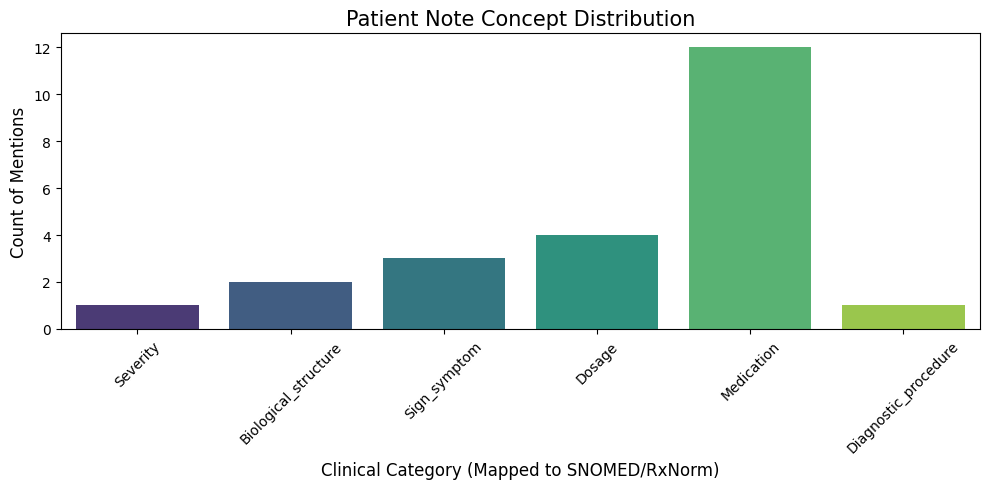

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# "What is this patient's profile?"
# Visualizing the distribution of medical concepts extracted.

plt.figure(figsize=(10, 5))
sns.countplot(data=df_clinical, x='Category', palette='viridis')
plt.title('Patient Note Concept Distribution', fontsize=15)
plt.xlabel('Clinical Category (Mapped to SNOMED/RxNorm)', fontsize=12)
plt.ylabel('Count of Mentions', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 🚀 Product Strategy & Application

**1. The "Safe Harbor" Value Prop:**  
By implementing the Redaction Layer (Step 1) *before* the Analytics Layer (Step 2), we enable the product to process data in the Cloud (OCI/AWS) without triggering HIPAA Business Associate Agreement (BAA) breaches for PHI.

**2. Revenue Cycle Management (RCM):**  
The extracted entities (e.g., "T2DM", "Hypertension", "Metformin") can be automatically mapped to **ICD-10** and **CPT** codes. A PM would prioritize this feature to reduce administrative coding time for hospital clients.

**3. Connection to Prior Work:**  
This pipeline mirrors the architecture I managed at Oracle (Log Filtering), but adapted for the high-stakes compliance requirements of the Healthcare sector.

I noticed a lot of Healthcare SaaS companies struggle with the 'Privacy vs. Innovation' trade-off or neglect privacy alltogether. To stay sharp, I built a prototype pipeline on GitHub that solves this.
I used Microsoft Presidio to auto-redact PHI—leveraging the kind of masking logic I used to manage at Oracle OCI. Then, I piped the clean data into a Biomedical Transformer model to extract medications and diagnoses.
It demonstrates how a PM should think: Security First (protect the patient), but then Value Extraction (get the data structured for the business).